In [ ]:
#Follow this one:https://www.kaggle.com/piplimoon/titanic/leaderboard-0-8134/run/207748

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from time import time

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
train = pd.read_csv("train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("test.csv", dtype={"Age": np.float64}, )

In [4]:
train_set = train.drop("Survived", axis = 1)
df_combo = pd.concat((train_set, test), axis = 0, ignore_index = True)

In [5]:
df_combo.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [7]:
df_combo.Embarked.describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

In [8]:
#S is the most common one.
df_combo["Embarked"] = df_combo["Embarked"].fillna("S")

In [9]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

In [10]:
df_combo.ix[3,2]

'Futrelle, Mrs. Jacques Heath (Lily May Peel)'

In [11]:
def get_surname(name):
    if '.' in name:
        return name.split(',')[0].strip()
    else:
        return 'Unknown'

In [12]:
df_combo.ix[20:40,2]

20                                 Fynney, Mr. Joseph J
21                                Beesley, Mr. Lawrence
22                          McGowan, Miss. Anna "Annie"
23                         Sloper, Mr. William Thompson
24                        Palsson, Miss. Torborg Danira
25    Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...
26                              Emir, Mr. Farred Chehab
27                       Fortune, Mr. Charles Alexander
28                        O'Dwyer, Miss. Ellen "Nellie"
29                                  Todoroff, Mr. Lalio
30                             Uruchurtu, Don. Manuel E
31       Spencer, Mrs. William Augustus (Marie Eugenie)
32                             Glynn, Miss. Mary Agatha
33                                Wheadon, Mr. Edward H
34                              Meyer, Mr. Edgar Joseph
35                       Holverson, Mr. Alexander Oskar
36                                     Mamee, Mr. Hanna
37                             Cann, Mr. Ernest 

In [ ]:
#print(df_combo.ix[4,2].split(',')[0].strip())

In [13]:
df_combo['Title'] = df_combo['Name'].map(lambda x: get_title(x))
df_combo['Surname'] = df_combo['Name'].map(lambda x: get_surname(x))

In [14]:
df_combo['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [15]:
#R_table(df_combo['Surname'])
Surname_Fam = pd.concat([df_combo['Surname'], df_combo[["SibSp", "Parch"]]], axis = 1)
Surname_Fam["Fam"] = Surname_Fam.Parch + Surname_Fam.SibSp + 1


In [16]:
df_combo = pd.concat([df_combo, Surname_Fam["Fam"]], axis = 1)
df_combo.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fam
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,2
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,2
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,1


In [17]:
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Major','Dr','Rev']:
        return 'Officer'
    #elif title in ['the Countess', 'Dona', 'Lady']:
    #    return 'Lady'
    #elif title in ['Don', 'Sir','Jonkheer']:
    #    return 'Sir'
    elif title in ['the Countess', 'Dona', 'Lady','Don', 'Sir','Jonkheer']:
        return 'Royalty'
    elif title in ['Mme','Mrs','Ms']:
        return 'Mrs'
    elif title in ['Miss','Mlle']:
        return 'Miss' 
    else:
        return title

In [18]:
df_combo['Title']=df_combo.apply(replace_titles, axis=1)


In [19]:
def R_table(x):
    ps = pd.Series([tuple(i) for i in x])
    counts = ps.value_counts()
    print( counts)

In [20]:
R_table(df_combo.Title)

(M, r)                   757
(M, i, s, s)             262
(M, r, s)                200
(M, a, s, t, e, r)        61
(O, f, f, i, c, e, r)     23
(R, o, y, a, l, t, y)      6
dtype: int64


In [21]:
Cabin_List = df_combo.loc[:,["Cabin"]]
Cabin_List = Cabin_List.fillna("UNK")
Cabin_Code = []
for j in Cabin_List.Cabin:
    Cabin_Code.append(j[0])
Cabin_Code = pd.DataFrame({"Deck" : Cabin_Code})
df_combo = pd.concat([df_combo, Cabin_Code], axis = 1)


In [22]:
df_combo.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fam,Deck
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,2,U
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,2,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,1,U
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,2,C
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,1,U


In [23]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0

df_combo["Fam"] = df_combo.loc[:,"Fam"].apply(Fam_label)


In [24]:
def Title_label(s):
    if (s == "Sir") | (s == "Lady"):
        return "Royalty"
    elif (s == "Dr") | (s == "Officer") | (s == "Rev"):
        return "Officer"
    else:
        return s
        
df_combo["Title"] = df_combo.loc[:,"Title"].apply(Title_label)    

In [25]:
def tix_clean(j):
    j = j.replace(".", "")
    j = j.replace("/", "")
    j = j.replace(" ", "")
    return j
    
df_combo[["Ticket"]] = df_combo.loc[:,"Ticket"].apply(tix_clean)

Ticket_count = dict(df_combo.Ticket.value_counts())

def Tix_ct(y):
    return Ticket_count[y]

df_combo["TicketGrp"] = df_combo.Ticket.apply(Tix_ct)
def Tix_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

df_combo["TicketGrp"] = df_combo.loc[:,"TicketGrp"].apply(Tix_label)   


In [26]:
df_combo.TicketGrp.head(10)

0    1
1    2
2    1
3    2
4    1
5    1
6    2
7    1
8    2
9    2
Name: TicketGrp, dtype: int64

In [27]:
df_combo.drop(["PassengerId", "Name", "Ticket",\
               "Surname", "Cabin", "Parch", "SibSp"], axis=1, inplace = True)


In [28]:
df_combo.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Fam,Deck,TicketGrp
0,3,male,22.0,7.2500,S,Mr,2,U,1
1,1,female,38.0,71.2833,C,Mrs,2,C,2
2,3,female,26.0,7.9250,S,Miss,1,U,1
3,1,female,35.0,53.1000,S,Mrs,2,C,2
4,3,male,35.0,8.0500,S,Mr,1,U,1


In [29]:
mask_Age = df_combo.Age.notnull()
Age_Sex_Title_Pclass = df_combo.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]

In [30]:
Age_Sex_Title_Pclass.head()

,Age,Title,Sex,Pclass
0,22.0,Mr,male,3
1,38.0,Mrs,female,1
2,26.0,Miss,female,3
3,35.0,Mrs,female,1
4,35.0,Mr,male,3


In [31]:
Filler_Ages = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()

In [32]:
Filler_Ages

Age
Title   Pclass Sex         
Master  1      male     6.0
        2      male     2.0
        3      male     6.0
Miss    1      female  30.0
        2      female  20.0
        3      female  18.0
Mr      1      male    41.5
        2      male    30.0
        3      male    26.0
Mrs     1      female  45.0
        2      female  30.0
        3      female  31.0
Officer 1      female  49.0
               male    52.0
        2      male    41.5
Royalty 1      female  39.0
               male    40.0

In [33]:
Filler_Ages = Filler_Ages.Age.unstack(level = -1).unstack(level = -1)

Filler_Ages

Sex     female              male            
Pclass       1     2     3     1     2     3
Title                                       
Master     NaN   NaN   NaN   6.0   2.0   6.0
Miss      30.0  20.0  18.0   NaN   NaN   NaN
Mr         NaN   NaN   NaN  41.5  30.0  26.0
Mrs       45.0  30.0  31.0   NaN   NaN   NaN
Officer   49.0   NaN   NaN  52.0  41.5   NaN
Royalty   39.0   NaN   NaN  40.0   NaN   NaN

In [34]:
mask_Age = df_combo.Age.isnull()
Age_Sex_Title_Pclass_missing = df_combo.loc[mask_Age, ["Title", "Sex", "Pclass"]]

def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age
    

In [35]:
Age_Sex_Title_Pclass_missing["Age"]  = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis = 1)   

In [37]:
df_combo["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])    


In [38]:
df_combo.fillna(df_combo[(df_combo.Embarked == "S") & (df_combo.Pclass == 3)].Fare.median(), inplace = True)


In [39]:
#df_combo[["Fare","Age"]]

In [40]:
#### OHE encoding nominal categorical features ###
df_combo = pd.get_dummies(df_combo)
df_combo.head()

,Pclass,Age,Fare,Fam,TicketGrp,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Title_Royalty,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,3,22.0,7.2500,2,1,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,38.0,71.2833,2,2,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,26.0,7.9250,1,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,35.0,53.1000,2,2,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,35.0,8.0500,1,1,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
df_train = df_combo.loc[0:len(train["Survived"])-1]
df_test = df_combo.loc[len(train["Survived"]):]
total_number_param = len(df_train.columns)
df_target = train.Survived

In [42]:
cv=StratifiedKFold(df_target.values,n_folds=10)
select = SelectKBest(k = 20)

In [ ]:
#scaler = StandardScaler()
#scaler.fit(df_combo[["Fare","Age"]])

#train_data_scaled = scaler.transform(train_data_munged[predictors])
#test_data_scaled = scaler.transform(test_data_munged[predictors])

# Logistic Regression

In [43]:
LogR = LogisticRegression(random_state=10)
#cv_score_LR = cross_val_score(LogR, df_train, df_target, cv=cv, n_jobs=-1,
#                         scoring=linear_scorer)



#print("Accuracy (logistic regression): {}/{}".format(scores.mean(), scores.std()))

In [44]:
LogR


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
LogR_model = LogisticRegression(random_state=10,warm_start=True)
params = [{
    #"C": [1.0,2.0,3.0],
    "intercept_scaling": [1,2,3],
    #"min_samples_split": [2],
    #"min_samples_leaf": [1,2,3],
    "max_iter":[100,200,300] 
}]
grid_search= GridSearchCV(LogR_model, params, cv=cv, refit=True, verbose=10, n_jobs=-1)
grid_search.fit(df_train.values,df_target.values)
RF_best = grid_search.best_estimator_

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] intercept_scaling=1, max_iter=100 ...............................
[CV] ...... intercept_scaling=1, max_iter=100, score=0.755556 -   0.1s
[CV] ...... intercept_scaling=1, max_iter=100, score=0.820225 -   0.1s
[CV] ...... intercept_scaling=1, max_iter=100, score=0.831461 -   0.1s
[CV] ...... intercept_scaling=1, max_iter=100, score=0.786517 -   0.1s
[CV] ...... intercept_scaling=1, max_iter=100, score=0.788889 -   0.1s
[CV] intercept_s

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1313s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0670s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.3s finished


In [46]:
grid_search.best_params_

{'intercept_scaling': 1, 'max_iter': 100}

In [47]:
pipeline_LR = make_pipeline(select, LogR) 
pipeline_LR.fit(df_train, df_target)
predictions_LR = pipeline_LR.predict(df_train)
predict_proba_LR = pipeline_LR.predict_proba(df_train)[:,1]

In [48]:
cv_score_LR = cross_val_score(LogR, df_train, df_target, cv=cv, n_jobs=-1)

print("Accuracy : %.4g" % metrics.accuracy_score(df_target.values, predictions_LR))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_target, predict_proba_LR))
print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_LR), np.std(cv_score_LR), 
np.min(cv_score_LR),
np.max(cv_score_LR)))

Accuracy : 0.8249
AUC Score (Train): 0.868626
CV Score : Mean - 0.8081855 | Std - 0.03537302 | Min - 0.7555556 | Max - 0.8651685


In [ ]:
final_pred1 = pipeline_LR.predict(df_test)
submission1 = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": final_pred1 })
submission1.to_csv("m1.csv", index=False) 

# Decision Tree 

In [49]:
decision_tree_calssifier=DecisionTreeClassifier(random_state = 10,
                                  #max_depth = 15, 
                                  max_features = 'sqrt')
parameter_grid={'max_depth':[7,8 ]}

cross_validation=StratifiedKFold(df_target.values,n_folds=10)
grid_search=GridSearchCV(decision_tree_calssifier,\
                         param_grid=parameter_grid,\
                        cv=cross_validation,verbose=3)

In [50]:
grid_search.fit(df_train.values,df_target.values)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] max_depth=7 .....................................................
[CV] ............................ max_depth=7, score=0.833333 -   0.0s
[CV] max_depth=7 .....................................................
[CV] ............................ max_depth=7, score=0.800000 -   0.0s
[CV] max_depth=7 .....................................................
[CV] ............................ max_depth=7, score=0.797753 -   0.0s
[CV] max_depth=7 .....................................................
[CV] ............................ max_depth=7, score=0.820225 -   0.0s
[CV] max_depth=7 .....................................................
[CV] ............................ max_depth=7, score=0.876404 -   0.0s
[CV] max_depth=7 .....................................................
[CV] ............................ max_depth=7, score=0.808989 -   0.0s
[CV] max_depth=7 .....................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ..., 1 0], n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=10, splitter='best'),
       fit_params={}, iid=True, n_jobs=1, param_grid={'max_depth': [7, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [51]:
grid_search.best_params_

{'max_depth': 7}

In [53]:
#decision_tree_calssifier=grid_search.best_estimator_
decision_tree_calssifier=DecisionTreeClassifier(random_state = 10,
                                  max_depth = 7, 
                                  max_features = 'sqrt')

In [54]:
pipeline_DR = make_pipeline(select, decision_tree_calssifier) 
pipeline_DR.fit(df_train, df_target)
predictions_DR = pipeline_DR.predict(df_train)
predict_proba_DR = pipeline_DR.predict_proba(df_train)[:,1]

In [55]:
cv_score_DR = cross_val_score(pipeline_DR, df_train, df_target, cv= cv)
print("Accuracy : %.4g" % metrics.accuracy_score(df_target.values, predictions_DR))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_target, predict_proba_DR))
print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_DR), np.std(cv_score_DR), 
np.min(cv_score_DR),
np.max(cv_score_DR)))

Accuracy : 0.8541
AUC Score (Train): 0.891730
CV Score : Mean - 0.8238157 | Std - 0.03880608 | Min - 0.7640449 | Max - 0.8988764


/Users/thein/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)


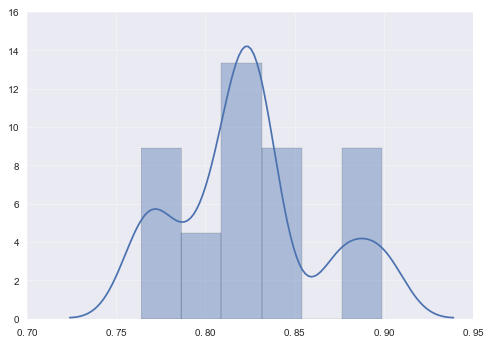

In [56]:
sb.distplot(cv_score_DR)

In [ ]:
final_pred1 = pipeline_DR.predict(df_test)
submission1 = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": final_pred1 })
submission1.to_csv("m2.csv", index=False) 

# Random Forest 

In [57]:


RF = RandomForestClassifier(random_state = 10, warm_start = True, 
                            n_estimators = 26,
                            #min_samples_leaf=1,
                            #min_samples_split=2,
                            max_depth = 6, 
                            max_features = 'sqrt')
pipeline_RF = make_pipeline(select, RF)               
 

In [58]:
RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True)

In [59]:
pipeline_RF.fit(df_train, df_target)
predictions_RF = pipeline_RF.predict(df_train)
predict_proba_RF = pipeline_RF.predict_proba(df_train)[:,1]

In [60]:

cv_score_RF = cross_val_score(pipeline_RF, df_train, df_target, cv= cv)
print("Accuracy : %.4g" % metrics.accuracy_score(df_target.values, predictions_RF))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_target, predict_proba_RF))
print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_RF), np.std(cv_score_RF), 
np.min(cv_score_RF),
np.max(cv_score_RF)))

Accuracy : 0.8732
AUC Score (Train): 0.922400
CV Score : Mean - 0.8417566 | Std - 0.03738464 | Min - 0.752809 | Max - 0.8876404


/Users/thein/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)


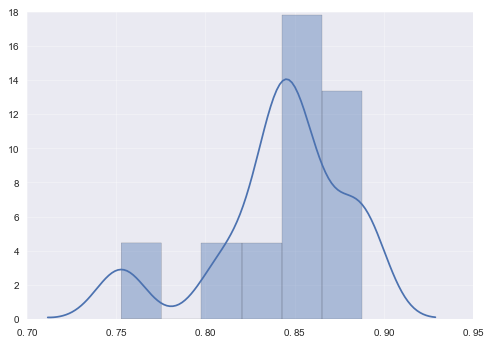

In [61]:
sb.distplot(cv_score_RF)

In [ ]:
final_pred = pipeline_RF.predict(df_test)
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": final_pred })
submission.to_csv("m3.csv", index=False) 

# Random Forest Tuning 

In [62]:

RF_model = RandomForestClassifier(random_state=10,max_features = 'sqrt')
params = [{
    "n_estimators": [25,26],
    #"min_samples_split": [2],
    #"min_samples_leaf": [1,2,3],
    "max_depth":[6] 
}]
a=grid_search= GridSearchCV(RF_model, params, cv=cv, refit=True, verbose=10, n_jobs=-1)
grid_search.fit(df_train.values,df_target.values)
RF_best = grid_search.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6, n_estimators=25 ....................................
[CV] ........... max_depth=6, n_estimators=25, score=0.844444 -   0.1s
[CV] ........... max_depth=6, n_estimators=25, score=0.764045 -   0.1s
[CV] ........... max_depth=6, n_estimators=25, score=0.833333 -   0.1s
[CV] ........... max_depth=6, n_estimators=25, score=0.887640 -   0.1s
[CV] max_depth=6, n_estimators=25 ....................................
[CV] max_depth=6

[Parallel(n_jobs=-1)]: Batch computation too fast (0.0846s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | 

[CV] ........... max_depth=6, n_estimators=26, score=0.829545 -   0.0s


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


In [ ]:
#report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
#print(report)

In [63]:
grid_search.best_params_

{'max_depth': 6, 'n_estimators': 26}

/Users/thein/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)


Accuracy : 0.8732
AUC Score (Train): 0.922400
CV Score : Mean - 0.8417566 | Std - 0.03738464 | Min - 0.752809 | Max - 0.8876404


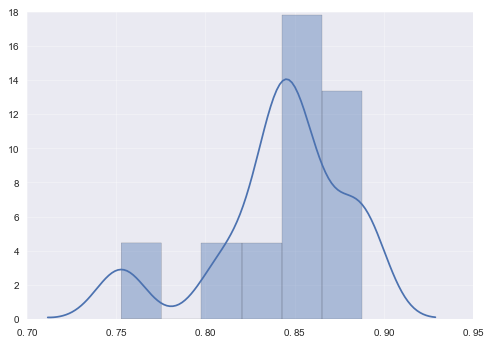

In [64]:
RF_best=grid_search.best_estimator_
pipeline_RF = make_pipeline(select, RF_best)               
pipeline_RF.fit(df_train, df_target)
predictions_RF = pipeline_RF.predict(df_train)
predict_proba_RF = pipeline_RF.predict_proba(df_train)[:,1]

cv_score_RF = cross_val_score(pipeline_RF, df_train, df_target, cv= cv)
print("Accuracy : %.4g" % metrics.accuracy_score(df_target.values, predictions_RF))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_target, predict_proba_RF))
print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_RF), np.std(cv_score_RF), 
np.min(cv_score_RF),
np.max(cv_score_RF)))
sb.distplot(cv_score_RF)

In [ ]:
final_pred2 = pipeline_RF.predict(df_test)
submission2 = pd.DataFrame({"PassengerId": titanic_test["PassengerId"], "Survived": final_pred2 })
submission2.to_csv("method5.csv", index=False) 

# Extreme Gradient Boosting  (XGB)

In [65]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(nthread=4)
xgb_model
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [66]:
cross_validation=StratifiedKFold(df_target.values,n_folds=10)
params1 = [{
    "n_estimators": [540,550,560],
     "max_depth": [2],
     "learning_rate": [ 0.03,0.05]
}]
#grid_search1= GridSearchCV(xgb_model, params1, cv=cv, refit=True, verbose=3, n_jobs=-1)
#grid_search1.fit(df_train.values,df_target.values)

grid_search2 = GridSearchCV(xgb_model, params1, n_jobs=5, 
                   cv=cross_validation, 
                   scoring='roc_auc',
                   verbose=3, refit=True)

In [67]:
grid_search2.fit(df_train.values,df_target.values)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=540, score=0.873506 -   0.4s
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=540, score=0.874286 -   0.5s
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=540, score=0.753743 -   0.5s
[CV] max_depth=2, learning_rate=0.03, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=540, score=0.903476 -   0.5s
[CV]  max_depth=2, learning_rate=0.03, n_estima

[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.4s


[CV]  max_depth=2, learning_rate=0.03, n_estimators=560, score=0.884492 -   0.5s
[CV] max_depth=2, learning_rate=0.05, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=560, score=0.872460 -   0.5s
[CV] max_depth=2, learning_rate=0.05, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=560, score=0.865241 -   0.5s
[CV] max_depth=2, learning_rate=0.05, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=560, score=0.932086 -   0.5s
[CV] max_depth=2, learning_rate=0.05, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.03, n_estimators=560, score=0.896514 -   0.5s
[CV] max_depth=2, learning_rate=0.05, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.05, n_estimators=540, score=0.882078 -   0.5s
[CV] max_depth=2, learning_rate=0.05, n_estimators=540 ...............
[CV]  max_depth=2, learning_rate=0.05, n_estimators=540, score=0.884675 -   0.5s
[CV] ma

[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    5.9s finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ..., 1 0], n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=5,
       param_grid=[{'max_depth': [2], 'learning_rate': [0.03, 0.05], 'n_estimators': [540, 550, 560]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=3)

In [68]:
print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 550}
0.879902741176


In [72]:
#xgb_best=grid_search1.best_estimator_
xgb_best=xgb_model = xgb.XGBClassifier(learning_rate=0.05,n_estimators=582,max_depth=2)

In [73]:
xgb_best.fit(df_train.values, df_target.values)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=582, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

/Users/thein/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)


Accuracy : 0.8911
AUC Score (Train): 0.935601
CV Score : Mean - 0.8407088 | Std - 0.03889098 | Min - 0.7640449 | Max - 0.8988764


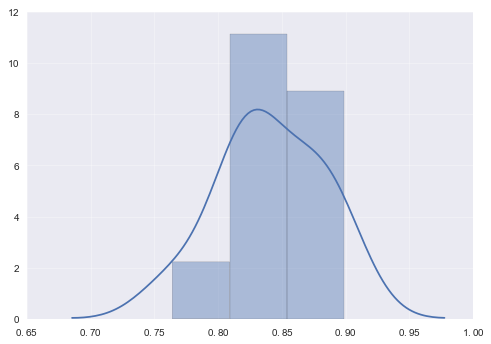

In [74]:
cv=StratifiedKFold(df_target.values,n_folds=10)
pipeline_RF = make_pipeline(select, xgb_best)               
pipeline_RF.fit(df_train, df_target)
predictions_RF = pipeline_RF.predict(df_train)
predict_proba_RF = pipeline_RF.predict_proba(df_train)[:,1]

cv_score_RF = cross_val_score(pipeline_RF, df_train, df_target, cv= cv)
print("Accuracy : %.4g" % metrics.accuracy_score(df_target.values, predictions_RF))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_target, predict_proba_RF))
print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_RF), np.std(cv_score_RF), 
np.min(cv_score_RF),
np.max(cv_score_RF)))
sb.distplot(cv_score_RF)

In [ ]:
final_pred2 = pipeline_RF.predict(df_test)
submission2 = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": final_pred2 })
submission2.to_csv("m4.csv", index=False) 